In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

,Extent,Date
0,1040455.516,1979-01-01
1,239334.118,1979-02-01
2,557365.154,1979-03-01
3,2054855.924,1979-04-01
4,2973925.625,1979-05-01
...,...,...
533,3137598.938,2023-06-01
534,3201783.453,2023-07-01
535,2973294.266,2023-08-01
536,3354839.711,2023-09-01


In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 5
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Ross_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((522, 12, 1), (522,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model_LT5/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 25s 327ms/step - loss: 0.3092 - root_mean_squared_error: 0.5560 - val_loss: 0.1473 - val_root_mean_squared_error: 0.3838
Epoch 2/50
53/53 [==============================] - 16s 307ms/step - loss: 0.0732 - root_mean_squared_error: 0.2705 - val_loss: 0.0665 - val_root_mean_squared_error: 0.2578
Epoch 3/50
53/53 [==============================] - 16s 306ms/step - loss: 0.0533 - root_mean_squared_error: 0.2308 - val_loss: 0.0601 - val_root_mean_squared_error: 0.2451
Epoch 4/50
53/53 [==============================] - 18s 336ms/step - loss: 0.0463 - root_mean_squared_error: 0.2153 - val_loss: 0.0524 - val_root_mean_squared_error: 0.2289
Epoch 5/50
53/53 [==============================] - 18s 348ms/step - loss: 0.0381 - root_mean_squared_error: 0.1953 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2039
Epoch 6/50
53/53 [==============================] - 19s 363ms/step - loss: 0.0293 - root_mean_squared_error: 0.1711 - val_loss: 0.0339 

Epoch 29/50
53/53 [==============================] - 3s 55ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 30/50
53/53 [==============================] - 17s 332ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0732
Epoch 31/50
53/53 [==============================] - 18s 348ms/step - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0688
Epoch 32/50
53/53 [==============================] - 18s 336ms/step - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0678
Epoch 33/50
53/53 [==============================] - 3s 56ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0767
Epoch 34/50
53/53 [==============================] - 3s 54ms/step - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0055 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

9.02546744743983 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

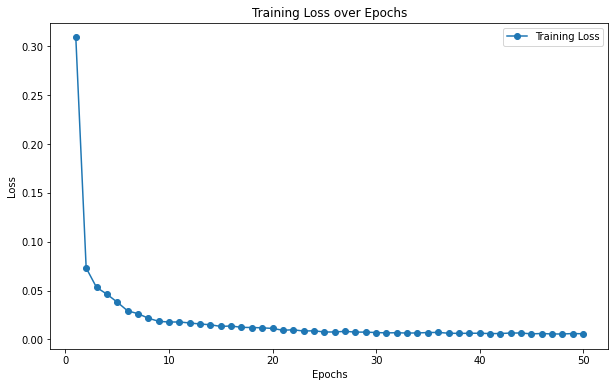

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

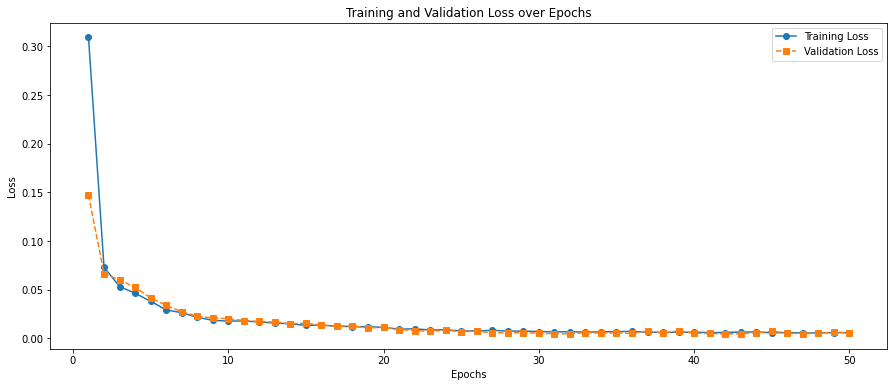

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model_LT5/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 26ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0834163376050527
MAE : 0.0626246127306311


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,3.976140e+06,3885746.442
1,3.836380e+06,3909211.179
2,3.409890e+06,3499167.351
3,2.594409e+06,2715890.297
4,1.119223e+06,1053272.694
5,3.295173e+05,368862.123
6,9.891509e+05,979418.298
7,1.885461e+06,2086269.569
8,2.587475e+06,2852731.016
9,3.053388e+06,3452823.613


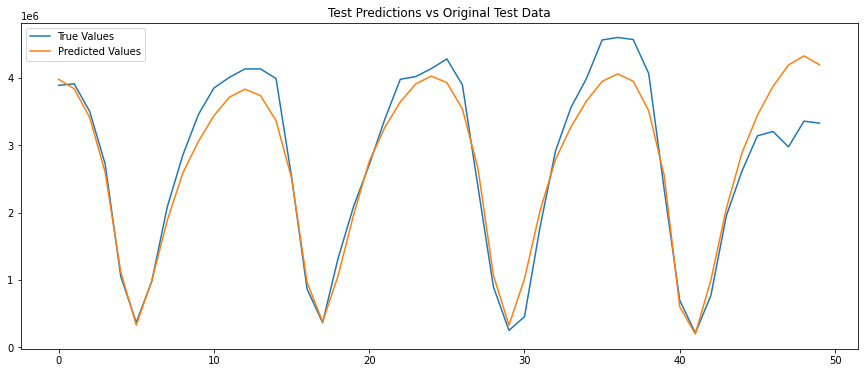

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 28ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

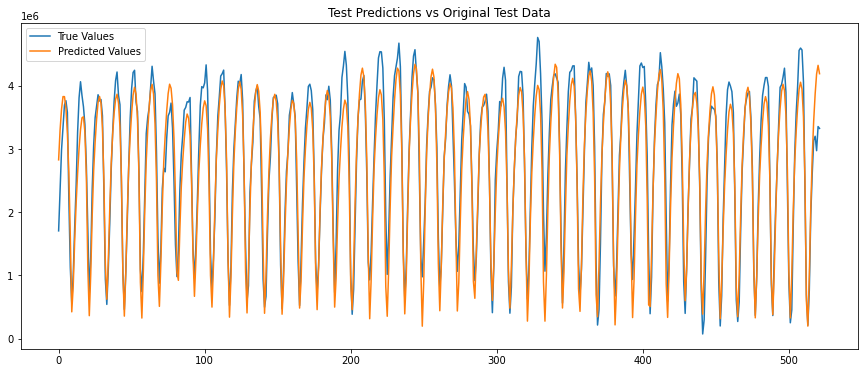

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()